# <div align="center"><b> APSERa Simulation Pipeline for Cross Orthogonal Polarization </b></div>


## <div align="center"><b>  Modified Code With Dual Polarized Antenna </b></div>

### Task 1.1: Generating a PySM Sky Model

In [ ]:
pip install pysm

In [ ]:
pip install ephem

In [ ]:
pip install camb

In [1]:
# For computation and mathematics
import numpy as np
import math
import ephem
from scipy.signal import correlate
from scipy.optimize import curve_fit
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline, RegularGridInterpolator

#For working with sky coordinates and similar such arrangements
import healpy as hp

#For plotting
import matplotlib.pyplot as plt
%matplotlib inline

#For generating sky model
import pysm3
import pysm3.units as u
from pysm3 import CMBMap

#Astronomical conversions
from astropy.timeseries import TimeSeries, BinnedTimeSeries
from astropy.time import Time, TimeDelta
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

#For working with data sets
import pandas as pd

#For CMB emission
import camb
from camb import model, initialpower

sky (no dimension) --> Importing PySM 3 sky emission model where "d1", "s1", "f1", "c1" represent various components used for the sky model. 

Ref. PySM 3 documentation

In [2]:
sky = pysm3.Sky(nside=16, preset_strings=["d1", "s1", "f1", "c1"])
sky.components  #checking the components of sky

This snippet can be used to define the required frequency range. This code takes the frequency range from a file.

In [3]:
# frequencies = np.linspace(2,4,100)*u.GHz
# freq = (2.88)*u.GHz
# print(freq)
# print(type(frequencies))

frequencies (1001,) --> List of frequencies from 2 - 4 GHz

freqs (1001,) --> List of frequencies from 2 - 4 GHz in astropy units (required to extract PySM 3 Sky model)

In [4]:
# extracting the frequencies from a csv file

pd.set_option('display.float_format', '{:.9f}'.format)   #setting the precision ofthe data taken
df = pd.read_csv("/home/pratush/APSERa_new/APSERa/APSERa_S11_Simulation.csv", dtype={'column_name': float}, index_col = None) #importing csv file
frequencies = df["Frequency"].values
frequencies = frequencies
freqs = frequencies*u.GHz
#print(frequencies.shape)
#print(frequencies)

This cell computes the impedance based on S11 measurements of the antenna. These impedance values can be used when considering non-ideal case.

In [5]:
#calculating impedance based on S11 data obtained

# S11 = df["S11"].values
# print(type(S11))
# Impedance = 50*((1+S11)/(1-S11))
# print(Impedance.shape)

polarized_maps (1001, 3, 3072) --> Sky Emission maps for frequencies ranging from 2 - 4 GHz

In [6]:
#extracting sky emissions for multiple frequencies

polarized_maps = [] 

for m in freqs:
    sky_maps = sky.get_emission(m, weights=None)
    sky_maps = sky_maps/1e6
    polarized_maps.append(sky_maps)
    #print(sky_maps)
    
polarized_maps = np.array(polarized_maps)
#print(type(polarized_maps))
#print(polarized_maps.shape)

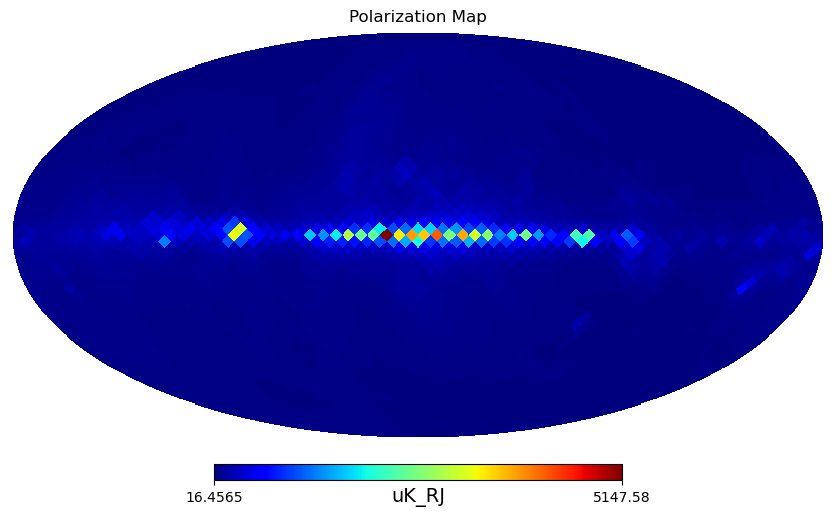

In [7]:
#combinig the maps for visualization

combined = np.sum(polarized_maps, axis = 0)
#print(combined.shape)
hp.mollview(combined[0,:], title='Polarization Map', cmap='jet', unit='uK_RJ')

### Task 2: Replace beam with analytical beam

start_time_in_UTC --> A string representing the current date and time in ISO format (e.g., '2023-10-03T12:34:56.789'). It's obtained using the datetime.now() function.

n_spectra --> The number of spectra to be taken, can range from 1 - infinity.

delta_t_in_hours --> The time interval between each spectrum in hours, set to 1 hour in this code.

t --> An instance of the Time class created from start_time_in_UTC. It represents a specific point in time and is used for time-related calculations.

ts --> A TimeSeries object representing a sequence of time instances. It starts from start_time_in_UTC and advances by delta_t_in_hours hours for each sample. The ts object contains the time instances for the spectra.

In [8]:
#Getting time and number of spectra

from datetime import datetime   # importing datetime module

start_time_in_UTC = str(datetime.now())
#print(start_time_in_UTC)

n_spectra = 1              #Number of spectra to be taken
delta_t_in_hours = 1       #Time interval between each spectra needed in hours

t = Time(start_time_in_UTC, format = 'iso', scale= 'utc')

ts = TimeSeries(time_start= start_time_in_UTC, time_delta= delta_t_in_hours *u.hour, n_samples= n_spectra)
ts = ts.time
print(ts)

['2023-10-09 10:54:33.064']


In [9]:
#Defining Antenna Beam

#Beam fucntion for Antenna 1
#Here: freq = frequency, alt = Altitude, az = Azimuth

def beam_def_A1(freq, alt, az):
    #return float(my_interpolating_function([freq, alt, az]))
    if (alt<=0):
        return 0
    else:
        return ((math.sin(alt*np.pi/180))**2)*(math.sin(az*np.pi/180))

In [10]:
#Beam fucntion for Antenna 2
#Here: freq = frequency, alt = Altitude, az = Azimuth

def beam_def_A2(freq, alt, az):
    #return float(my_interpolating_function([freq, alt, az]))
    if (alt<=0):
        return 0
    else:
        return ((math.sin(alt*np.pi/180))**2)*(math.cos(az*np.pi/180))

In [11]:
#Basic Definitions - all of them being in SI Units

h = 6.62607157e-34                         # Plank's Constant
K_Bolt = 1.3806488e-23                     # Boltzmann Constant
c = 2.99792458e+08                         # Speed of light
TCMB = 2.72548                             # CMB Temperature
f_start = 2                                # Check the f_start and f_stop and change the number of channels accordingly. Can be used to define frequency range.
f_stop = 4                                 # Frequency range end point
No_of_Channels = 1001                      # no.of frequency channels i.e. number of frequencies into consideration
Channel_width = 0.01 
nside = 16                                 # Parameter which determines the resolution of HealPy map.
T_hot = 3730                               # Hot temerature threshold for absolute calibration - in Kelvin units.
T_cold = 2730                              # Cold temerature threshold for absolute calibration - in Kelvin units.
Time_in_UTC = ts                           # It represents the time in Coordinated Universal Time (UTC) when the spectra or observations are taken
latitude = 13.067439                       # Longitude in degrees
longitude =80.237617                       # Latitude in degrees
altitude = 0                               # Altitude in meters
alpha = 0.0065                             # Temp. lapse rate (deg C per meter) dry adiabatic lapse rate" (DALR), and it describes how the temperature of dry air changes with altitude as it rises in the Earth's atmosphere.
PI = 3.14159265                            # Pi value
Noise_int_time = 3e+13                     # It specifies the integration time for noise calculations in the systematics.
Trx = 14                                   # It represents the receiver noise temperature in Kelvin.
T_atm = 1                                  # It represents the atmospheric noise temperature in Kelvin. 
num_components = 3                         #no. of components in the sky emission i.e. I, Q & U


# These variables are used to define the dimensions


P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)
 
Voltage_Real = [0]*No_of_Channels 
cross_real = [0]*No_of_Channels
cross_imag = [0]*No_of_Channels
sumwt = [0]*No_of_Channels
sigma = np.zeros(No_of_Channels)
spectra = [0]*n_spectra
spectra_cross_imag = [0]*n_spectra

Voltage_Real_A2 = [0]*No_of_Channels
cross_real2 = [0]*No_of_Channels
cross_imag2 = np.zeros(No_of_Channels)
sumwt2 = [0]*No_of_Channels
sigma2 = np.zeros(No_of_Channels)
spectra2 = [0]*n_spectra
spectra_cross_imag2 = [0]*n_spectra

cross_real3 = [0]*No_of_Channels
cross_imag3 = np.zeros(No_of_Channels)
sumwt3 = [0]*No_of_Channels
sigma3 = np.zeros(No_of_Channels)
spectra3 = [0]*n_spectra
spectra_cross_imag3 = [0]*n_spectra

cross_real4 = [0]*No_of_Channels
cross_imag4 = np.zeros(No_of_Channels)
sumwt4 = [0]*No_of_Channels
sigma4 = np.zeros(No_of_Channels)
spectra4 = [0]*n_spectra
spectra_cross_imag4 = [0]*n_spectra

npix = hp.nside2npix(nside)

The code defines a Python function refraction(alt_in_deg, altitude) that calculates the apparent altitude of an object in the sky after accounting for atmospheric refraction. 

alt_in_deg --> This parameter represents the true altitude of the object in degrees.

altitude --> This parameter represents the observer's altitude above sea level in meters.

The function performs the following steps:

1. pres --> Calculates the atmospheric pressure using a simplified form of the barometric formula. It takes into account the altitude of the observer.

2. Checks if the observer's altitude is greater than 11,000 meters. If so, it sets the temperature (temp) to 211.5 Kelvin. Otherwise, it calculates temp based on the given formula.

3. Calculates the refraction angle R using the formula provided. This formula is used to correct for atmospheric refraction and is based on the U.S. Naval Observatory's Vector Astrometry Software. The formula takes the true altitude (alt_in_deg) and converts it to the apparent altitude after refraction.

4. Handles a special case where alt_in_deg is exactly 90 degrees. In this case, a small correction (0.0019279) is added to R.

5. Calculates a temperature and pressure correction factor (tpcor) based on the atmospheric pressure and temperature.

6. Finally, it computes the corrected altitude by multiplying tpcor with R (converted from arcminutes to degrees) and adding it to the true altitude.

In [12]:
#Refraction correction formula

def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)     #Simplified Barometric formula
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))  #This formula is used in the U. S. Naval Observatory's Vector Astrometry Software
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)             #converting from arcminutes to degrees
    return alt_in_deg +R

Obs --> It defines the observer's location, date, and time for astronomical observations.

t --> It sets the observer's date and time.

lst --> This line calculates the local apparent sidereal time (LST) at the given observer's location and time (t). (LST is the angle in the sky measured eastward from the vernal equinox and is used in astronomy to determine the right ascension of celestial objects.)

In [13]:
Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location= EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m))
lst = t.sidereal_time('apparent')
print(lst)

print(beam_def_A1(3.7,71.9,279.7))
print(beam_def_A2(2.8,70,30))

[17h26m43.13306463s]
-0.8905635240930115
0.7647196759766884


In [14]:
npix = hp.nside2npix(nside)     #  This line calculates the total number of pixels for a given HEALPix resolution specified by nside.
theta, phi = hp.pix2ang(nside, np.arange(npix), nest=True)    #finding theta and phi value for each pixel in healpix map
#print (npix,theta, phi)
#plt.plot(theta,npix)
#plt.plot(phi,npix)

P_hot (1001,) --> This represents the power or intensity associated with a "hot" load or source. In the context of calibration, a hot load is a reference source with a known temperature (in this case, represented by T_hot) used to calibrate the receiver system. The formula used to calculate P_hot is derived from Planck's radiation law.

P_cold (1001,) --> This variable represents the power or intensity associated with a "cold" load or source. Similar to P_hot, a cold load is another reference source with a known temperature (in this case, represented by T_cold) used for calibration. 

P_dif (1001,) --> The subtraction of the power associated with the hot load from the power associated with the cold load.

In [15]:
#P_hot and P_cold for calibration
P_hot = (2*h*frequencies*1e9)/(np.exp((h*frequencies*1e9)/(K_Bolt*T_hot))-1)
P_cold = (2*h*frequencies*1e9)/(np.exp((h*frequencies*1e9)/(K_Bolt*T_cold))-1)
P_dif = P_hot -P_cold

/tmp/ipykernel_88090/3609134933.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(recomb_file,sep= "    " ,header = None)


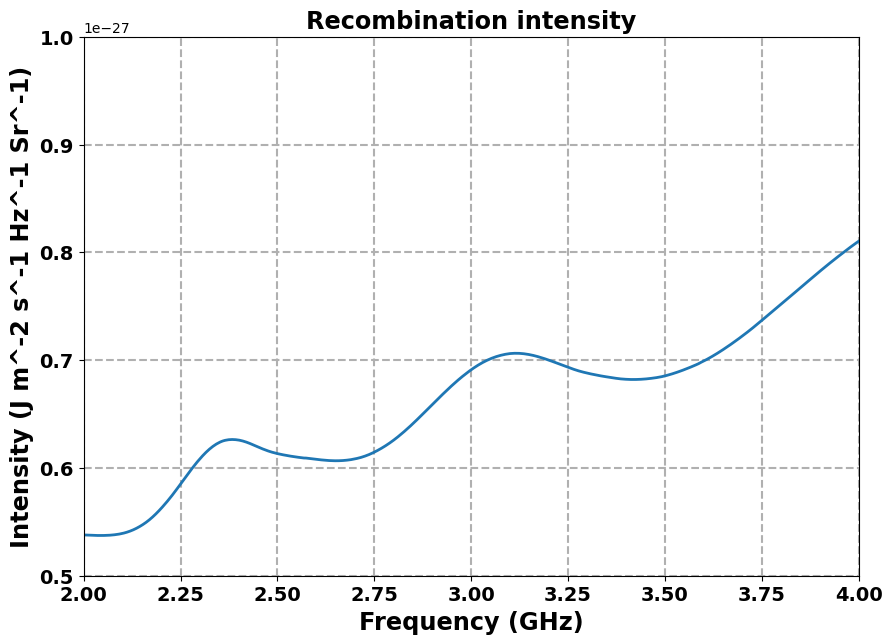

In [16]:
#Getting recombination lines

import os

recomb_path = "/home/pratush/APSERa_new/APSERa/APSERa_Files"
recomb_file = os.path.join(recomb_path,'total_spec_new.txt')
df = pd.read_csv(recomb_file,sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]

x = df["Frequency"]
y= df["Intensity"]

plt.figure(figsize=(10, 7))
plt.plot((df['Frequency']), (df['Intensity']),linewidth=2)
plt.title('Recombination intensity', fontsize='xx-large', fontweight='bold')
plt.xlabel('Frequency (GHz)', fontsize='xx-large', fontweight='bold')
plt.ylabel('Intensity (J m^-2 s^-1 Hz^-1 Sr^-1)', fontsize='xx-large', fontweight='bold')
plt.xlim([f_start,f_stop])
plt.ylim([0.5e-27,1e-27])
plt.xticks(fontsize = 14, fontweight='bold')
plt.yticks(fontsize = 14, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

ius = InterpolatedUnivariateSpline(x, y)
Rec_int = ius(frequencies)  # array takes dimensions of the frequency


## Task 3: Getting Spectra

### Task 3.1.1: Getting CMB Intensity

num_components --> This represents the number of Stokes parameters we are working with.

pars --> This line initializes the parameters for the CAMB (Code for Anisotropies in the Microwave Background) cosmological simulation code. 

pars.set_cosmology --> This sets various cosmological parameters such as the Hubble constant (H0), baryon density (ombh2), and cold dark matter density (omch2) among others.

pars.InitPower.set_params --> This sets parameters related to the initial power spectrum of primordial fluctuations, including amplitude (As) and spectral index (ns).

pars.set_for_lmax --> This sets parameters for the maximum multipole moment (lmax) used in calculations and specifies the accuracy for lensing potential calculations.

Using the hp.synfast function from the Healpy library, it generates a CMB map for the given frequency and Stokes parameter. 

The "cmb_power" is used as input to synthesize the map. The resulting CMB maps are stored in the "cmb_maps" array.

cmb_temp (1001, 3, 3072) -->  It is correcting for fluctuations by adding the temperature of the CMB.

In [17]:
num_components = 3  # Number of Stokes parameters (I, Q, U)

# Initialize CAMB parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122) 
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(3 * nside - 1, lens_potential_accuracy=0)

# Initialize the CAMB results object
results = camb.get_results(pars)

# Initialize an array to store CMB maps with the same shape as polarized_maps
cmb_maps = np.empty([No_of_Channels, num_components, npix])

# Generate CMB maps for each frequency and Stokes parameter
for i, freq_GHz in enumerate(frequencies):
    # Calculate CMB power spectra for the frequency
    powers = results.get_cmb_power_spectra(pars)
    
    # Loop through each Stokes parameter
    for j in range(num_components):
        cmb_power = powers['total'][2:3 * nside, j]  # Power spectrum for the component
        
        # Generate CMB map for the frequency and Stokes parameter
        cmb_maps[i, j] = hp.synfast(cmb_power, nside, new=True, verbose=False, fwhm=0)

# Now cmb_maps contains the CMB maps with the same shape as polarized_maps

cmb_temp = cmb_maps + TCMB # Correcting for CMB fluctuations

/tmp/ipykernel_88090/4021244597.py:25: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  cmb_maps[i, j] = hp.synfast(cmb_power, nside, new=True, verbose=False, fwhm=0)


[[2.72544905 2.72542181 2.72523318 ... 2.72542577 2.72565881 2.72541195]
 [2.72531828 2.72561639 2.72557096 ... 2.72532938 2.72557358 2.72532384]
 [2.7256456  2.72547512 2.72541615 ... 2.72557033 2.72537851 2.72573772]
 ...
 [2.72560529 2.72589822 2.72561893 ... 2.72530009 2.72558176 2.72535567]
 [2.72543092 2.72546709 2.7251997  ... 2.72555584 2.7255486  2.7252592 ]
 [2.72538353 2.72562597 2.72551882 ... 2.725484   2.72554934 2.72532798]]


<Figure size 640x480 with 0 Axes>

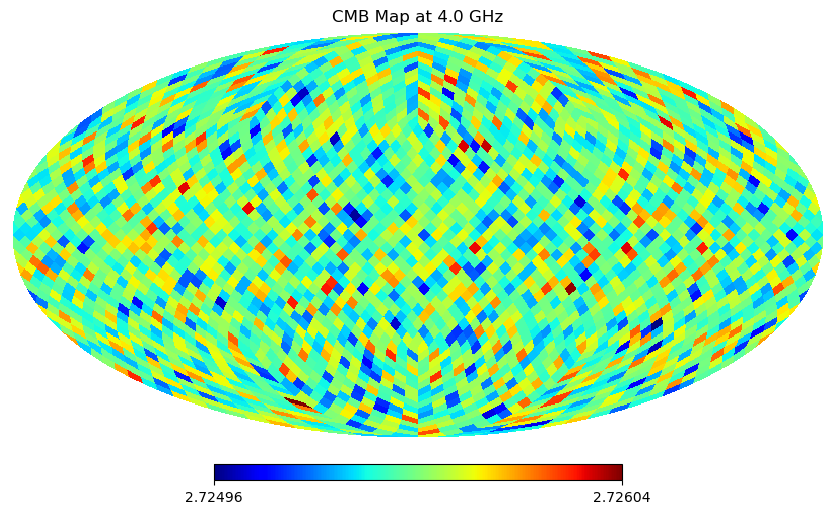

In [18]:
print(cmb_temp[:,0,:])        #checking shape of CMB map
plt.figure()
hp.mollview(cmb_temp[4,0,:], title=f"CMB Map at {freq_GHz} GHz", cmap="jet")

### Task 3.2: Spectra for Antenna 1

Power_Spectrum (1001, ) --> List to store power spectra for each channel.

Voltage_Ideal (1001,) --> List to store voltage for each channel considering an ideal impedance of 50 ohms.

Voltage_Ideal_Beam (1001,) --> List to store voltage with beam correction for each channel considering an ideal impedance of 50 ohms.

coords --> Galactic coordinates of a pixel (in HealPy).

gc --> SkyCoord object representing the coordinates in Galactic frame.

equi --> Coordinates transformed to Equatorial frame with refraction correction.

alt --> Altitude value after refraction correction.

longitudes --> Azimuthal angles.

cwt --> Beam weight associated with a specific frequency channel.

polarized_maps --> Sky Emission maps for each channel from PySM 3.

maps --> Conversion of sky emission obtained from PySM 3 from temperature scale to intensity scale using Rayleigh Jeans Law.

cmb_temp --> Cosmic Microwave Background temperature for each channel.

cmb_intensity --> Temperature of CMB converted to intensity scale using Rayleigh Jeans Law.

Power --> Conversion of sky emission from intensity to power (in Watts)

Voltage_Real --> List to store voltages for each channel considering real impedance obtained from S11 measurements of the antenna (not used in the provided code).

final_temp --> Final temperature after power conversion and absolute calibration.

cross_real (1001,) --> List to store real part of the cross-correlation for each channel.

sumwt (1001,) --> List to store sum of beam weights for each channel.

sigma (1001,) --> List to store sigma values for each channel.

cross_imag (1001,) --> List to store imaginary part of the cross-correlation for each channel.

spectra (1, 1001) --> Array to store spectra containing intensity infomation.

In [19]:
Power_Spectrum = [0]*No_of_Channels
Voltage_Ideal = [0]*No_of_Channels
Voltage_Ideal_Beam = [0]*No_of_Channels

t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below and finding actual altitude after refraction correction
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude)  
        #print('Alt:', new_alt)
        
        j = 0
        longitudes = equi.az.value  #These azimuthal angles can be useful for determining the direction in which celestial objects are located when observed from a specific location on Earth at a given time.
        #print('Lon:', longitudes)
        
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt = beam_def_A1(frequencies[j], new_alt, longitudes) #weight associated with the specific frequency channel
            
            if (cwt>0):     #Adding all the three intensities

                #temperature conversion to intensity units using Rayleigh-Jeans Law
                maps = (2 * K_Bolt * 1e+18 * (frequencies[j]**2) * polarized_maps[j,0,i-1]) / (c**2)  
                #print('maps:', maps)

                cmb_intensity = (2 * K_Bolt * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
                #print('CMB_Int:', cmb_intensity) 

                # Converting the emission from intensity units to power units
                # Multiply by square root of (1 - Gamma^2) when using real impedance values for teh antenna. 
                Power = (maps + cmb_intensity + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2)) * cwt
                #print('Power:', Power)
                
                Power_Spectrum[j] = Power_Spectrum[j] + Power
    
                #Voltage_Real[j] = Voltage_Real[j] + (np.sqrt(2 * Power * Impedance[j]))  # Voltage calculation for Antenna 1 with S11 values
                #print('Voltage_Real', Voltage_Real)

                Voltage_Ideal[j] = Voltage_Ideal[j] + (np.sqrt(2 * Power * 50))
                
                final_temp = (Power/P_dif[j])*(T_hot-T_cold)
                #print('Final_temp:', final_temp)
                
                cross_real[j] = cross_real[j] + final_temp
                #print('Cross_real:',cross_real)
                
                sumwt[j] = sumwt[j]+ cwt
                #print('sumwt:',sumwt[j])

            j = j+1
            
        if (i%1000 == 0):
             print('Number of pixels got: ', i)
        
        i += 1
    
    i = 0
    while(i < No_of_Channels):
        if sumwt[i]>0:
            cross_real[i] = cross_real[i]/sumwt[i]
            Voltage_Ideal_Beam[i] = Voltage_Ideal[i]/(np.sqrt(sumwt[i]))
            Power_Spectrum[i] = Power_Spectrum[i]/sumwt[i]
            #Voltage_Real[i] = Voltage_Real[i]/sumwt[i]
        i = i+1
    
    sigma = (np.array(cross_real) + Trx + T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
    #print('Sigma:', sigma)
    #print('Sigma:', sigma.shape, sigma)

    #Generating an array of random integers with mean 0 and std 1. 
    array = np.random.normal(0, 1, No_of_Channels)
    #print(type(array))
    #print('array:', array.shape, array)

    #Adding the gaussian error
    cross_real = cross_real + array * sigma
    #print('cross_real:', cross_real)
    
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag = cross_imag + array *  sigma 
    #print('cross_imag:', cross_imag.shape, cross_imag, type(cross_imag))
    
    spectra[t] = cross_real
    #print('spectra:', spectra[t])
    
    spectra_cross_imag[t] = cross_imag
    #print('spectra:', len(spectra), spectra, type(spectra))

    cross_real = [0]*No_of_Channels
    cross_imag = [0]*No_of_Channels
    sumwt = [0]*No_of_Channels
    sigma = np.zeros(No_of_Channels)
    
    print("No. of spectra got = ", t+1)
        
    t += 1 

Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000
No. of spectra got =  1


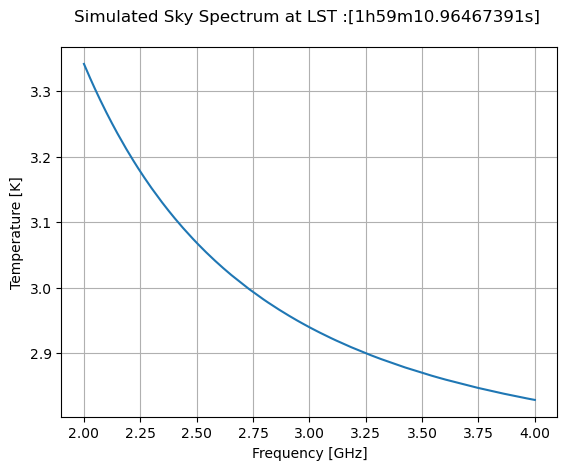

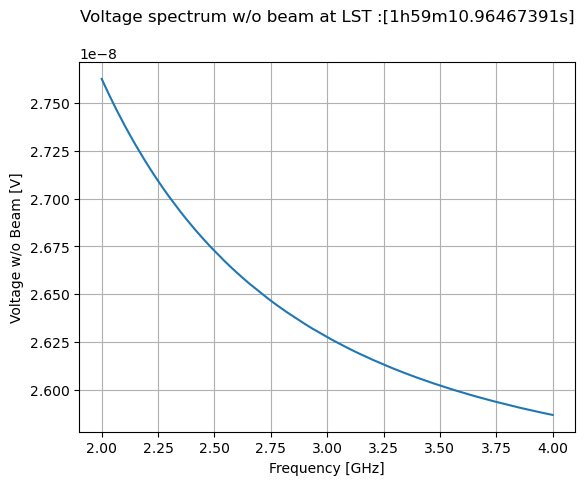

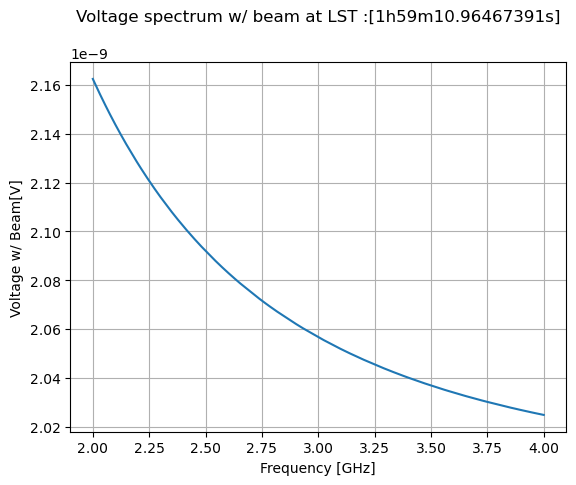

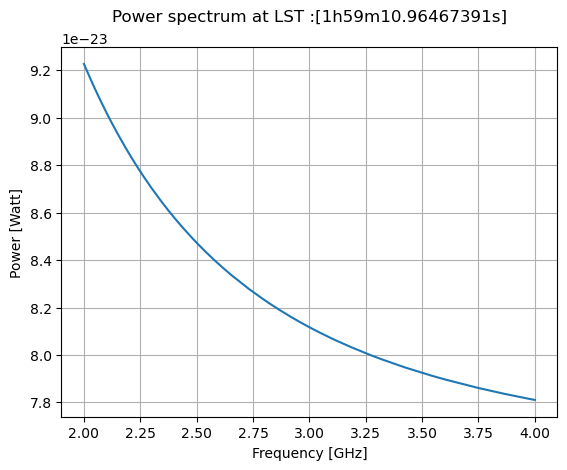

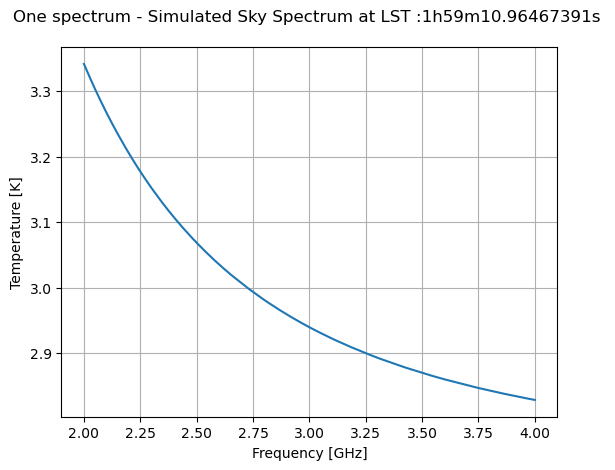

In [20]:
i=0
while(i<n_spectra):
    plt.plot(freqs, spectra[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()

plt.plot(frequencies,Voltage_Ideal)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Voltage w/o Beam [V]')
plt.title('Voltage spectrum w/o beam at LST :%s\n '%lst)
plt.grid()
plt.show()

plt.plot(frequencies,Voltage_Ideal_Beam)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Voltage w/ Beam[V]')
plt.title('Voltage spectrum w/ beam at LST :%s\n '%lst)
plt.grid()
plt.show()

plt.plot(frequencies,Power_Spectrum)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Power [Watt]')
plt.title('Power spectrum at LST :%s\n '%lst)
plt.grid()
plt.show()

plt.plot(frequencies, spectra[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Spectrum at LST :%s \n'%lst[0])
plt.grid()
plt.show()

In [21]:
Power_Spectrum2 = [0]*No_of_Channels
Voltage_Ideal_A2 = [0]*No_of_Channels
Voltage_Ideal_Beam_A2 = [0]*No_of_Channels

t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
        
        j = 0
        longitudes = equi.az.value
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt2 = beam_def_A2(frequencies[j], new_alt, longitudes) #weight associated with the specific frequency channel 
            
            if (cwt2>0):     #Adding all the three intensities

                maps2 = (2 * K_Bolt * 1e+18 * (frequencies[j]**2) * polarized_maps[j,0,i-1]) / (c**2)
                #print(maps)
                
                cmb_intensity2 = (2 * K_Bolt * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
                
                Power2 = (maps2 + cmb_intensity2 + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2)) * cwt2
                #print(Power2)
                
                Power_Spectrum2[j] = Power_Spectrum2[j] + Power2
                
                #Voltage_Real_A2[j] = Voltage_Real_A2[j] + (np.sqrt(2 * Power2 * Impedance[j]))  # Volate calculation for Antenna 1 with S11 values
                #print(Voltage_Real)
                
                Voltage_Ideal_A2[j] = Voltage_Ideal_A2[j] + (np.sqrt(2 * Power2 * 50))
                
                final_temp2 = (Power2/P_dif[j])*(T_hot-T_cold)
                #print(type(final_temp))
                
                cross_real2[j] = cross_real2[j] + final_temp2
                #print(cross_real[j])
                
                sumwt2[j] = sumwt2[j]+ cwt2
                #print(sumwt[j])
                        
            j += 1
            
            
        if (i%1000 == 0):
            print('Number of pixels got: ', i)
        
        i += 1
        
    i = 0
    while(i< No_of_Channels):
        if sumwt2[i]>0:
            cross_real2[i] = cross_real2[i]/sumwt2[i]
            #Voltage_Real_A2[i] = Voltage_Real_A2[i]/sumwt2[i]
            Voltage_Ideal_Beam_A2[i] = Voltage_Ideal_A2[i]/np.sqrt(sumwt2[i])
            Power_Spectrum2[i] = Power_Spectrum2[i]/sumwt2[i]
        i = i+1

    sigma2 = (np.array(cross_real2) + Trx+ T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
    #print(type(sigma))


    #Generating an array of random integers with mean 0 and std 1. 
    array2 = np.random.normal(0, 1, No_of_Channels)

    #Adding the gaussian error


    cross_real2 = cross_real2 + array2 * sigma2
    #print(cross_real2)
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag2 = cross_imag2 + array2 * sigma2

    spectra2[t] = cross_real2
    spectra_cross_imag2[t] = cross_imag2

    cross_real2 = [0]*No_of_Channels
    cross_imag2 = [0]*No_of_Channels
    sumwt2 = [0]*No_of_Channels
    sigma2 = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)


    t += 1 


Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000
No. of spectra got =  1


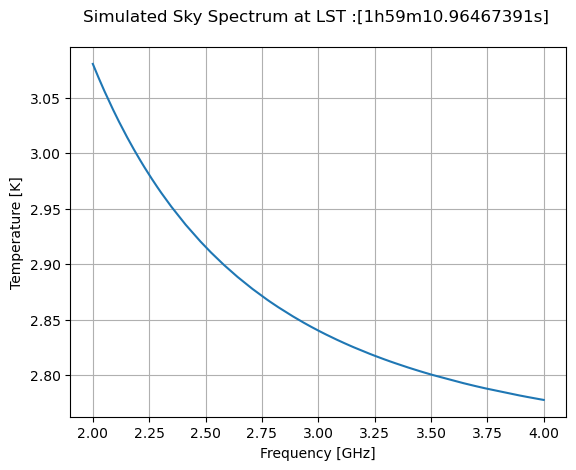

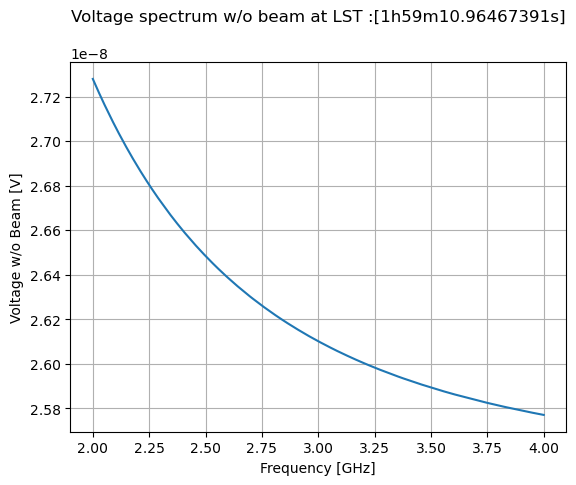

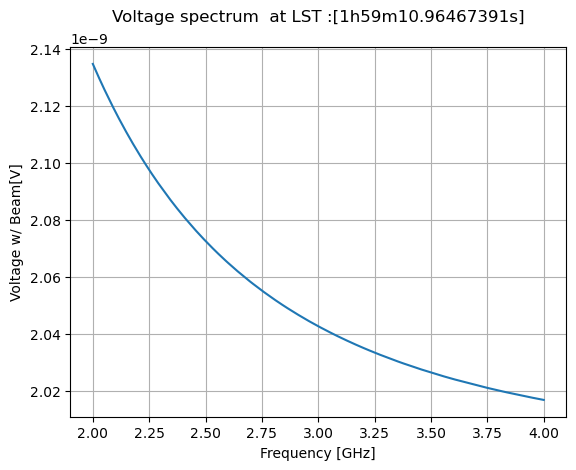

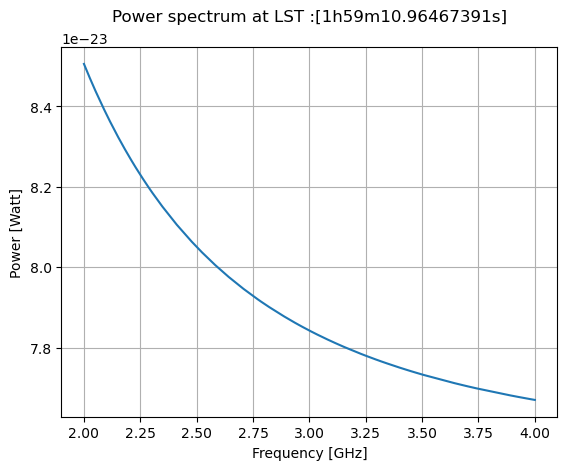

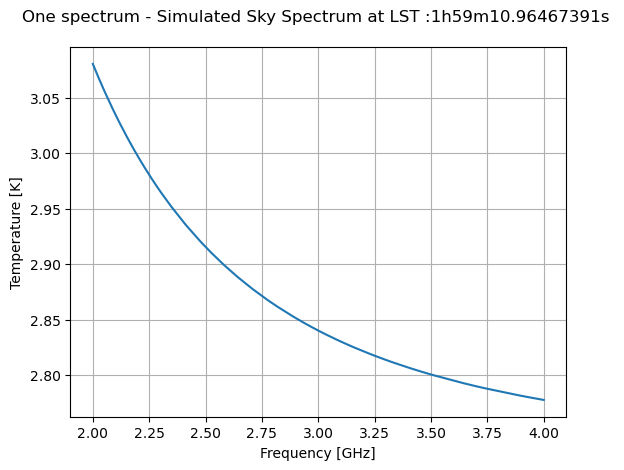

In [22]:
i=0
while(i<n_spectra):
    plt.plot(freqs, spectra2[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()

plt.plot(frequencies,Voltage_Ideal_A2)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Voltage w/o Beam [V]')
plt.title('Voltage spectrum w/o beam at LST :%s\n '%lst)
plt.grid()
plt.show()

plt.plot(frequencies,Voltage_Ideal_Beam_A2)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Voltage w/ Beam[V]')
plt.title('Voltage spectrum  at LST :%s\n '%lst)
plt.grid()
plt.show()

plt.plot(frequencies,Power_Spectrum2)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Power [Watt]')
plt.title('Power spectrum at LST :%s\n '%lst)
plt.grid()
plt.show()

plt.plot(frequencies, spectra2[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Spectrum at LST :%s \n'%lst[0])
plt.grid()
plt.show()

### Task 3.3 Finding Stokes parameters from both the antenna spectras

#### Task 3.3.1 Calculating Electric Field for Antenna 1 from Obtained Voltage Information

In [23]:
# Voltage_Real = np.array(Voltage_Real)
Voltage_Ideal = np.array(Voltage_Ideal)

In [24]:
len_eff = []       # finding effective length of the antenna based on frequencies
for f in frequencies:
    length = c / (2 * f * 1e+9)
    len_eff.append(length)
len_eff = np.array(len_eff)

For non-ideal antenna condition

In [25]:
# Ele_field_1 = []  #Finding electric field for antenna 1
# for i in range(len(len_eff)):
#     E = Voltage_Real[i] / len_eff[i] 
#     Ele_field_1.append(E)

For ideal antenna condition

In [26]:
Ele_field_1 = []  #Finding electric field for antenna 1
for i in range(len(len_eff)):
    E = Voltage_Ideal[i] / len_eff[i] 
    Ele_field_1.append(E)

#### Task 3.3.1 Calculating Electric Field for Antenna 1 from Obtained Voltage Information

In [27]:
# Voltage_A2 = np.array(Voltage_Real_A2)
Voltage_Ideal_A2 = np.array(Voltage_Ideal_A2)

In [28]:
len_eff_2 = []       # finding effective length of the antenna 2 based on frequencies
for f in frequencies:
    length2 = c / (2 * f * 1e+9)
    len_eff_2.append(length2)
len_eff_2 = np.array(len_eff_2)

For non-ideal antenna condition

In [29]:
# Ele_field_2 = []  #Finding electric field for antenna 1
# for i in range(len(len_eff_2)):
#     E2 = Voltage_Real_A2[i] / len_eff_2[i] 
#     Ele_field_2.append(E2)

For ideal antenna condition

In [30]:
Ele_field_2 = []  #Finding electric field for antenna 1
for i in range(len(len_eff_2)):
    E2 = Voltage_Ideal_A2[i] / len_eff_2[i] 
    Ele_field_2.append(E2)

In [31]:
Ele_field_1 = np.array(Ele_field_1) 
Ele_field_2 = np.array(Ele_field_2) 

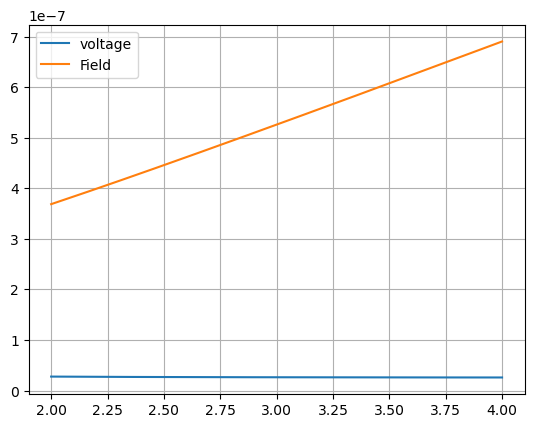

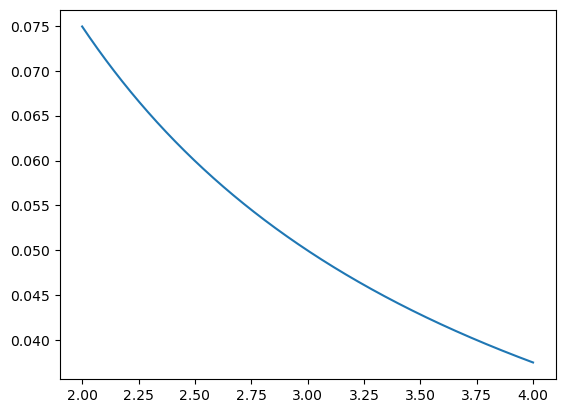

In [32]:
plt.plot(frequencies,Voltage_Ideal,label='voltage')
plt.plot(frequencies,Ele_field_1,label='Field')
plt.grid()
plt.legend()
plt.show()

plt.plot(frequencies,len_eff)
plt.show()

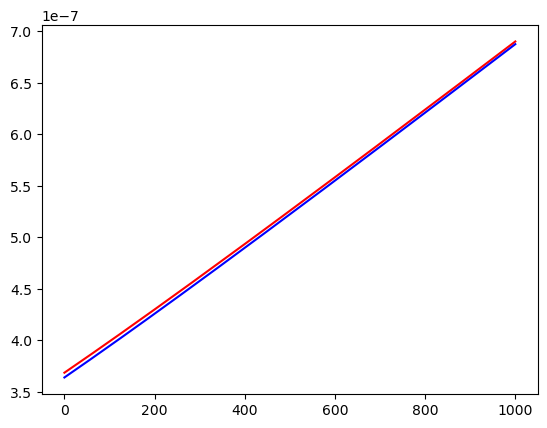

In [33]:
plt.plot(Ele_field_1, 'r')
plt.plot(Ele_field_2, 'b')
plt.show()

#### Task 3.3.3. Computing I, Q, U, V based on electric fields

Use this code when taking real-time impedance of an antenna system into consideration otherwise use the next cell.

In [34]:
# I = (((Ele_field_1**2)/Impedance) + ((Ele_field_2**2)/Impedance))
# Q = (((Ele_field_1**2)/Impedance) - ((Ele_field_2**2)/Impedance))
# U = (2*Ele_field_1*Ele_field_2)/Impedance
# V = [0]*No_of_Channels                                                                                         

# plt.plot(frequencies, I_test, 'r')
# plt.show()
# # plt.plot(frequencies, Q, 'b')
# # plt.show()
# # plt.plot(frequencies, U, 'c')
# # plt.show()

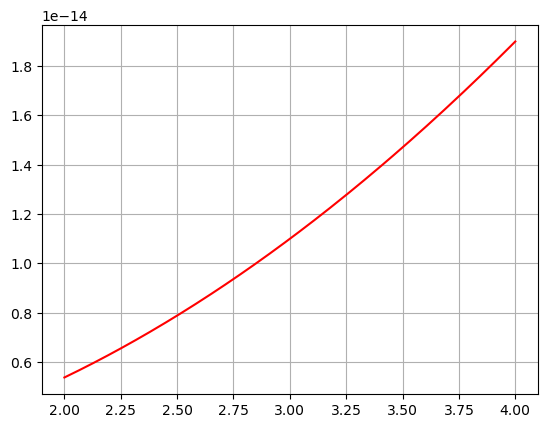

In [35]:
I = (((Ele_field_1**2)/50) + ((Ele_field_2**2)/50))
Q = (((Ele_field_1**2)/50) - ((Ele_field_2**2)/50))
U = (2*Ele_field_1*Ele_field_2)/50
V = [0]*No_of_Channels 
plt.plot(frequencies, I, 'r')
# plt.plot(frequencies, Q, 'b')
# plt.plot(frequencies, U, 'c')
plt.grid()
plt.show()

In [36]:
#Making a 2D matrix of I, Q, U and V

I = np.array(I)
Q = np.array(Q)
U = np.array(U)
V = np.array(V)

Sky_Pol = np.stack((I, Q, U, V))

In [37]:
identity = np.identity(4) # Muellur Matrix for the antenna

In [38]:
#Carrying out matrix multiplication to compute Final Stokes parameters

Final_Pol = np.zeros((4,1001))
for i in range(len(identity)):
   # iterate through columns of Y
   for j in range(len(Sky_Pol[0])):
       # iterate through rows of Y
       for k in range(len(Sky_Pol)):
           Final_Pol[i][j] += identity[i][k] * Sky_Pol[k][j]

for r in Final_Pol:
   print(r)

[5.36687903e-15 5.37570543e-15 5.38452802e-15 ... 1.89522640e-14
 1.89705892e-14 1.89889299e-14]
[6.78410767e-17 6.78693739e-17 6.78957600e-17 ... 7.18049597e-17
 7.17738130e-17 7.18557719e-17]
[5.36645023e-15 5.37527698e-15 5.38409994e-15 ... 1.89521280e-14
 1.89704534e-14 1.89887940e-14]
[0. 0. 0. ... 0. 0. 0.]


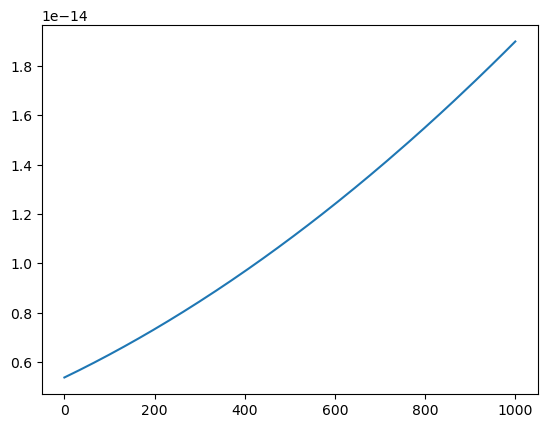

In [39]:
plt.plot(Final_Pol[0,:])

In [40]:
#Extracting individual I, Q, U, V

I_dash = Final_Pol[0,:]
Q_dash = Final_Pol[1,:]
U_dash = Final_Pol[2,:]
V_dash = Final_Pol[3,:]

#### 3.3.4. Computing the I Spectra

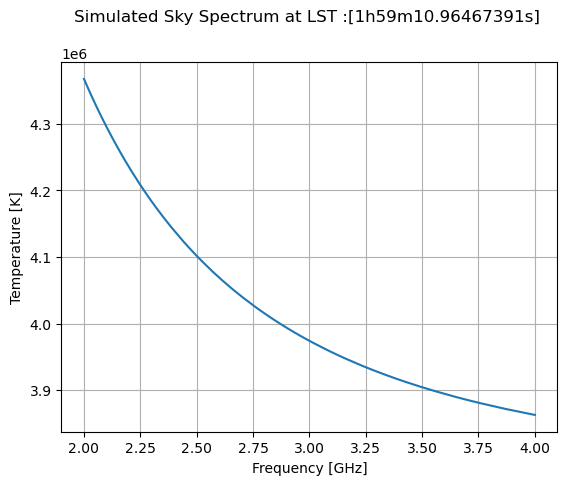

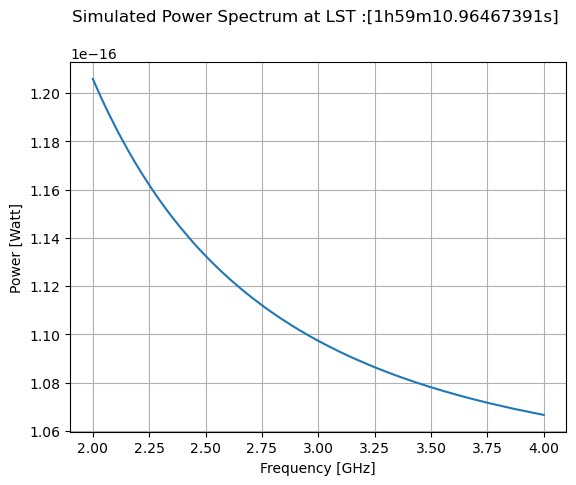

In [41]:
Power_I = I * (c**2 / (1e+18 * frequencies**2))
Stokes_I = (Power_I/P_dif)*(T_hot-T_cold)

plt.plot(freqs, Stokes_I)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()

plt.plot(freqs, Power_I)
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Power [Watt]')
plt.title('Simulated Power Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()


#### 3.3.4. Computing the Q Spectra

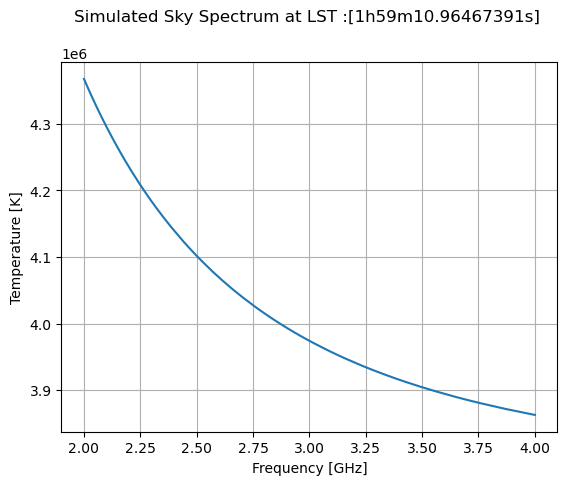

In [42]:
Power_I = I_dash * (c**2 / (1e+18 * frequencies**2))
Stokes_I = (Power_I/P_dif)*(T_hot-T_cold)

plt.plot(freqs, Stokes_I)
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()

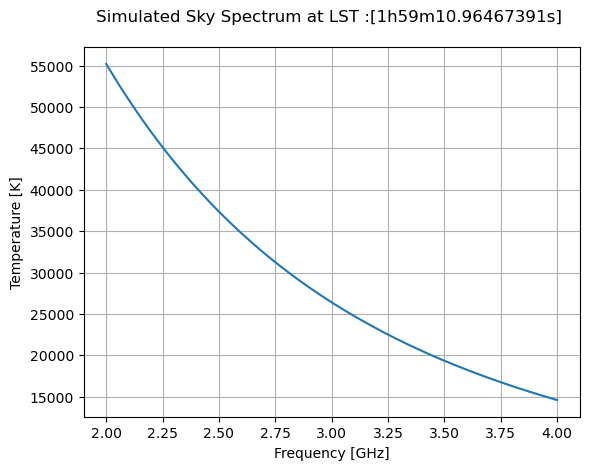

In [43]:
Power_Q = Q_dash * (c**2 / (1e+18 * frequencies**2))
Stokes_Q = (Power_Q/P_dif)*(T_hot-T_cold)

plt.plot(freqs, Stokes_Q)
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()


#### 3.3.5 Computing  the U spectra

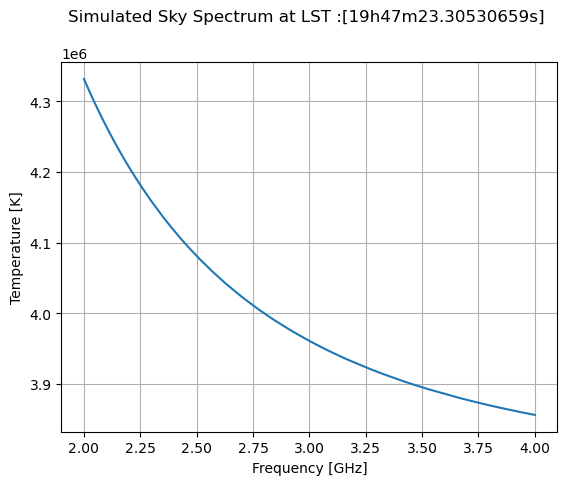

In [42]:
Power_U = U_dash * (c**2 / (1e+18 * frequencies**2))
Stokes_U = (Power_U/P_dif)*(T_hot-T_cold)

plt.plot(freqs, Stokes_U)
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()

### Task 3.4: Difference Spectra from both the antennas

In [ ]:
Diff = np.array(spectra)-np.array(spectra2)
print(Diff.shape)

In [ ]:
i=0
while(i<n_spectra):
    plt.plot(freqs, Diff[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Difference Spectrum from both the antenna beams at LST :%s\n '%lst)
plt.grid()
plt.show()

plt.plot(freqs, Diff[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Difference Spectrum from both the antenna beams at LST :%s \n'%lst[0])
plt.grid()
plt.show()

### Task 4: Replacing antennas beams with a different analytical beam (Spherical Harmonic Functions)

In [ ]:
#Defining Antenna Beam 2

#Beam fucntion for Antenna 1
#Here: freq = frequency, alt = Altitude, az = Azimuth

def beam_def2_A1(freq, alt, az):
    #return float(my_interpolating_function([freq, alt, az]))
    if (alt<=0):
        return 0
    else:
        return (math.sqrt(3/(4*np.pi))*math.sin(alt*np.pi/180)*(math.cos(az*np.pi/180)))
    
#Defining Antenna Beam

#Beam fucntion for Antenna 2
#Here: freq = frequency, alt = Altitude, az = Azimuth

def beam_def2_A2(freq, alt, az):
    #return float(my_interpolating_function([freq, alt, az]))
    if (alt<=0):
        return 0
    else:
        return (math.sqrt(3/(4*np.pi))*math.sin(alt*np.pi/180)*(math.sin(az*np.pi/180)))
    

In [ ]:
Voltage_A3 = [] 
Voltage_I3 = [] #Voltage for ideal antenna

In [ ]:
t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
        
        j = 0
        longitudes = equi.az.value
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt3 = beam_def2_A1(frequencies[j]*1e+9, new_alt, longitudes) #weight associated with the specific frequency channel 
            #print(type(cwt))
            #print(new_alt,cwt)
            #print(f"Spectrum {t+1}, Pixel {i}, Frequency {freqs[j]/1e9:.2f} GHz:")
            #print(f"   Altitude: {new_alt:.2f} degrees, Beam Response: {cwt:.2f}")
            
            if (cwt3>0):     #Adding all the three intensities

                maps3 = (2 * k * 1e+18 * (frequencies[j]**2) * polarized_maps[j,0,i-1]) / (c**2)
                #print(maps)
                
                cmb_intensity3 = (2 * k * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
                
                Power3 = (maps3 + cmb_intensity3 + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2))
                #print(Power2)
                
                Voltage_Ideal_A3 = np.sqrt(2 * Power * 50)  # Volate calculation for Antenna 3 with Z = 50 ohms
                #print(Voltage_Ideal)
                Voltage_I3.append(Voltage_Ideal_A3)
                
                Voltage_Real_A3 = np.sqrt(2 * Power * Impedance[j])  # Volate calculation for Antenna 3 with S11 values
                #print(Voltage_Real)
                Voltage_A3.append(Voltage_Real_A3)
                
                final_temp3 = (Power3/P_dif[j])*(T_hot-T_cold)
                #print(type(final_temp))
                
                cross_real3[j] = cross_real3[j] + cwt3 * final_temp3
                #print(cross_real[j])
                
                sumwt3[j] = sumwt3[j]+ cwt3
                #print(sumwt[j])
                        
            j += 1
            
            
        if (i%1000 == 0):
            print('Number of pixels got: ', i)
        
        i += 1
        
    i = 0
    while(i< No_of_Channels):
        if sumwt3[i]>0:
            cross_real3[i] = cross_real3[i]/sumwt3[i]
        i = i+1

    sigma3 = (np.array(cross_real3) + Trx+ T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
    #print(type(sigma))


    #Generating an array of random integers with mean 0 and std 1. 
    array3 = np.random.normal(0, 1, No_of_Channels) 

    #Adding the gaussian error


    cross_real3 = cross_real3 + array3 * sigma3
    print(cross_real3)
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag3 = cross_imag3 + array3 * sigma3

    spectra3[t] = cross_real3
    spectra_cross_imag3[t] = cross_imag3

    cross_real3 = [0]*No_of_Channels
    cross_imag3 = [0]*No_of_Channels
    sumwt3 = [0]*No_of_Channels
    sigma3 = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)


    t += 1 

In [ ]:
i=0
while(i<n_spectra):
    plt.plot(freqs, spectra3[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s\n'%lst)
plt.grid()
plt.show()

plt.plot(freqs, spectra3[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Spectrum at LST :%s \n'%lst[0])
plt.grid()
plt.show()

In [ ]:
Voltage_A4 = [] 
Voltage_I4 = [] #Voltage for ideal antenna

In [ ]:
t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
        
        j = 0
        longitudes = equi.az.value
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt4 = beam_def2_A2(freqs[j], new_alt, longitudes) #weight associated with the specific frequency channel 
            #print(type(cwt))
            #print(new_alt,cwt)
            #print(f"Spectrum {t+1}, Pixel {i}, Frequency {freqs[j]/1e9:.2f} GHz:")
            #print(f"   Altitude: {new_alt:.2f} degrees, Beam Response: {cwt:.2f}")
            
            if (cwt4>0):     #Adding all the three intensities

                maps4 = (2 * k * 1e+18 * (frequencies[j]**2) * polarized_maps[j,0,i-1]) / (c**2)
                #print(maps)
                cmb_intensity3 = (2 * k * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
                
                Power4 = (maps4 + cmb_intensity4 + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2))
                #print(Power2)
                
                Voltage_Ideal_A4 = np.sqrt(2 * Power * 50)  # Volate calculation for Antenna 4 with Z = 50 ohms
                #print(Voltage_Ideal)
                Voltage_I4.append(Voltage_Ideal_A4)
                
                Voltage_Real_A4 = np.sqrt(2 * Power * Impedance[j])  # Volate calculation for Antenna 4 with S11 values
                #print(Voltage_Real)
                Voltage_A4.append(Voltage_Real_A4)
                
                final_temp4 = (Power4/P_dif[j])*(T_hot-T_cold)
                #print(type(final_temp))
                
                cross_real4[j] = cross_real4[j] + cwt4 * final_temp4
                #print(cross_real[j])
                
                sumwt4[j] = sumwt4[j]+ cwt4
                #print(sumwt[j])
                        
            j += 1
            
            
        if (i%1000 == 0):
            print('Number of pixels got: ', i)
        
        i += 1
        
    i = 0
    while(i< No_of_Channels):
        if sumwt4[i]>0:
            cross_real4[i] = cross_real4[i]/sumwt4[i]
        i = i+1

    sigma4 = (np.array(cross_real4) + Trx+ T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
    #print(type(sigma))


    #Generating an array of random integers with mean 0 and std 1. 
    array4 = np.random.normal(0, 1, No_of_Channels)  

    #Adding the gaussian error


    cross_real4 = cross_real4 + array4 * sigma4
    print(cross_real4)
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag4 = cross_imag4 + array4 * sigma4

    spectra4[t] = cross_real4
    spectra_cross_imag4[t] = cross_imag4

    cross_real4 = [0]*No_of_Channels
    cross_imag4 = [0]*No_of_Channels
    sumwt4 = [0]*No_of_Channels
    sigma4 = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)


    t += 1 

In [ ]:
i=0
while(i<n_spectra):
    plt.plot(freqs, spectra4[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s \n'%lst)
plt.grid()
plt.show()

plt.plot(freqs, spectra4[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Spectrum at LST :%s \n'%lst[0])
plt.grid()
plt.show()

In [ ]:
Diff2 = np.array(spectra3)-np.array(spectra4)
print(Diff2.shape)

In [ ]:
i=0
while(i<n_spectra):
    plt.plot(freqs, Diff2[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Difference Spectrum from both the antenna beams at LST :%s \n'%lst)
plt.grid()
plt.show()

plt.plot(freqs, Diff2[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Difference Spectrum from both the antenna beams at LST :%s \n'%lst[0])
plt.grid()
plt.show()

### Task 5: Power conversion to Voltage

In [ ]:
Voltage_A3 = np.array(Voltage_A3)
Voltage_I3 = np.array(Voltage_I3)

len_eff_3 = []       # finding effective length of the antenna 3 based on frequencies
wavelength3 = [] 
for f in frequencies:
    wl3 = c / f * 1e+9
    wavelength3.append(wl3)
    length3 = c / (2 * f * 1e+9)
    len_eff_3.append(length3)
len_eff_3 = np.array(len_eff_3)

len_eff_4 = []       # finding effective length of the antenna 4 based on frequencies
wavelength4 = [] 
for f in frequencies:
    wl4 = c / f * 1e+9
    wavelength4.append(wl4)
    length4 = c / (2 * f * 1e+9)
    len_eff_4.append(length4)
len_eff_4 = np.array(len_eff_4)

Ele_field_3 = []  #Finding electric field for antenna 3
for i in range(len(len_eff_3)):
    E3 = Voltage_A3[i] / len_eff_3[i] 
    Ele_field_3.append(E3)

Ele_field_4 = []  #Finding electric field for antenna 4
for i in range(len(len_eff_4)):
    E4 = Voltage_A4[i] / len_eff_4[i] 
    Ele_field_4.append(E4)    
    
Ele_field_3 = np.array(Ele_field_3)
Ele_field_4 = np.array(Ele_field_4)

plt.plot(Ele_field_3, 'r', marker = '1')
plt.plot(Ele_field_4, 'b', marker = '_')
# plt.plot(Ele_field_2-Ele_field_1, 'k', marker = '_')

Q3_4 = (((Ele_field_1**2)/Impedance) -  ((Ele_field_2**2)/Impedance))

In [ ]:
plt.plot(frequencies, Q3_4)

### Trail for Mueller Matrix

In [ ]:
t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below and finding actual altitude after refraction correction
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude)  
        #print('Alt:', new_alt)
        
        j = 0
        longitudes = equi.az.value  #These azimuthal angles can be useful for determining the direction in which celestial objects are located when observed from a specific location on Earth at a given time.
        #print('Lon:', longitudes)
        
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt = beam_def_A1(frequencies[j], new_alt, longitudes) #weight associated with the specific frequency channel 
            #print(cwt)
            #print(type(cwt))
            #print(new_alt,cwt)
            #print(f"Spectrum {t+1}, Pixel {i}, Frequency {freqs[j]/1e9:.2f} GHz:")
            #print(f"   Altitude: {new_alt:.2f} degrees, Beam Response: {cwt:.2f}")
            
            if (cwt>0):     #Adding all the three intensities
                
                #print(polarized_maps[j,0,i-1])

                maps = (2 * k * 1e+18 * (frequencies[j]**2) * polarized_maps[j,0,i-1]) / (c**2)  #temperature conversion to intensity units
#                 Rayleigh-Jeans Law
#                 print('maps:', maps)

                cmb_intensity = (2 * k * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
#                 print('CMB_Int:', cmb_intensity)    
    
                Power = (maps + cmb_intensity + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2))
#                 print('Power:', Power)
                
                final_temp = (Power/P_dif[j])*(T_hot-T_cold)
#                 print('Final_temp:', final_temp)
                
                cross_real[j] = cross_real[j] + cwt*final_temp
#                 print('Cross_real:',cross_real)
                
                sumwt[j] = sumwt[j]+ cwt
#                 print('sumwt:',sumwt[j])

            #print('Cross_real_j:',cross_real.shape)
            j = j+1
            
        if (i%1000 == 0):
             print('Number of pixels got: ', i)
        
        i += 1
        #print('Cross_real_i:',cross_real.shape)
        
    i = 0
    while(i< No_of_Channels):
        if sumwt[i]>0:
            cross_real[i] = cross_real[i]/sumwt[i]
        i = i+1
        

    sigma = (np.array(cross_real) + Trx + T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
#     print('Sigma:', sigma)
#     print('Sigma:', sigma.shape, sigma)

    #Generating an array of random integers with mean 0 and std 1. 
    array = np.random.normal(0, 1, No_of_Channels)
#     print(type(array))
#     print('array:', array.shape, array)

    #Adding the gaussian error
    cross_real = cross_real + array * sigma
#     print('cross_real:', cross_real)
    
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag = cross_imag + array *  sigma 
#     print('cross_imag:', cross_imag.shape, cross_imag, type(cross_imag))
    
    spectra[t] = cross_real
#     print('spectra:', spectra[t])
    
    spectra_cross_imag[t] = cross_imag
#     print('spectra:', len(spectra), spectra, type(spectra))

    cross_real = [0]*No_of_Channels
    cross_imag = [0]*No_of_Channels
    sumwt = [0]*No_of_Channels
    sigma = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)
            
    t += 1 


In [28]:
cross_real_Q = [0]*No_of_Channels
cross_imag_Q = np.zeros(No_of_Channels)
sumwt_Q = [0]*No_of_Channels
sigma_Q = np.zeros(No_of_Channels)
spectra_Q = [0]*n_spectra
spectra_cross_imag_Q = [0]*n_spectra

cross_real_U = [0]*No_of_Channels
cross_imag_U = np.zeros(No_of_Channels)
sumwt_U = [0]*No_of_Channels
sigma_U = np.zeros(No_of_Channels)
spectra_U = [0]*n_spectra
spectra_cross_imag_U = [0]*n_spectra

In [29]:
t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below and finding actual altitude after refraction correction
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude)  
        #print('Alt:', new_alt)
        
        j = 0
        longitudes = equi.az.value  #These azimuthal angles can be useful for determining the direction in which celestial objects are located when observed from a specific location on Earth at a given time.
        #print('Lon:', longitudes)
        
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt_Q = beam_def_A1(frequencies[j], new_alt, longitudes) #weight associated with the specific frequency channel 
            #print(cwt)
            #print(type(cwt))
            #print(new_alt,cwt)
            #print(f"Spectrum {t+1}, Pixel {i}, Frequency {freqs[j]/1e9:.2f} GHz:")
            #print(f"   Altitude: {new_alt:.2f} degrees, Beam Response: {cwt:.2f}")
            
            if (cwt_Q>0):     #Adding all the three intensities
                
                #print(polarized_maps[j,0,i-1])

                maps_Q = (2 * K_Bolt * 1e+18 * (frequencies[j]**2) * polarized_maps[j,1,i-1]) / (c**2)  #temperature conversion to intensity units
#                 Rayleigh-Jeans Law
#                 print('maps:', maps)

                cmb_intensity = (2 * K_Bolt * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
#                 print('CMB_Int:', cmb_intensity)    
    
                Power_Q = (maps_Q + cmb_intensity + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2))
#                 print('Power:', Power)
                
                final_temp_Q = (Power_Q/P_dif[j])*(T_hot-T_cold)
#                 print('Final_temp:', final_temp)
                
                cross_real_Q[j] = cross_real_Q[j] + cwt_Q*final_temp_Q
#                 print('Cross_real:',cross_real)
                
                sumwt_Q[j] = sumwt_Q[j]+ cwt_Q
#                 print('sumwt:',sumwt[j])

            #print('Cross_real_j:',cross_real.shape)
            j = j+1
            
        if (i%1000 == 0):
             print('Number of pixels got: ', i)
        
        i += 1
        #print('Cross_real_i:',cross_real.shape)
        
    i = 0
    while(i< No_of_Channels):
        if sumwt_Q[i]>0:
            cross_real_Q[i] = cross_real_Q[i]/sumwt_Q[i]
        i = i+1
        

    sigma_Q = (np.array(cross_real_Q) + Trx + T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
#     print('Sigma:', sigma)
#     print('Sigma:', sigma.shape, sigma)

    #Generating an array of random integers with mean 0 and std 1. 
    array = np.random.normal(0, 1, No_of_Channels)
#     print(type(array))
#     print('array:', array.shape, array)

    #Adding the gaussian error
    cross_real_Q = cross_real_Q + array * sigma_Q
#     print('cross_real:', cross_real)
    
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag_Q = cross_imag_Q + array *  sigma_Q 
#     print('cross_imag:', cross_imag.shape, cross_imag, type(cross_imag))
    
    spectra_Q[t] = cross_real_Q
#     print('spectra:', spectra[t])
    
    spectra_cross_imag_Q[t] = cross_imag_Q
#     print('spectra:', len(spectra), spectra, type(spectra))

    cross_real_Q = [0]*No_of_Channels
    cross_imag_Q = [0]*No_of_Channels
    sumwt_Q = [0]*No_of_Channels
    sigma_Q = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)
    
#     print('Sigma:', sigma.shape, sigma)
#     print('array:', array.shape, array)
#     print('cross_real:', cross_real.shape, cross_real)
#     print('cross_img:', cross_img.shape, cross_imag)
#     print('spectra:', spectra.shape, spectra)
#     print('spectra_cross_imag', spectra_cross_imag.shape, spectra_cross_imag)

        
    t += 1 
    
    
    
#     print('Cross_real:', cross_real_spectra)
#     print('Cross_img:', cross_img)
#     print('spectra:', Spectra)
#     print("Shape of cross_real_spectra:", cross_real_spectra.shape)

Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000
No. of spectra got =  1


In [31]:
t = 0
while t < n_spectra:
    i = 1
    while i < npix:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = True, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below and finding actual altitude after refraction correction
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude)  
        #print('Alt:', new_alt)
        
        j = 0
        longitudes = equi.az.value  #These azimuthal angles can be useful for determining the direction in which celestial objects are located when observed from a specific location on Earth at a given time.
        #print('Lon:', longitudes)
        
        while j < No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt_U = beam_def_A1(frequencies[j], new_alt, longitudes) #weight associated with the specific frequency channel 
            #print(cwt)
            #print(type(cwt))
            #print(new_alt,cwt)
            #print(f"Spectrum {t+1}, Pixel {i}, Frequency {freqs[j]/1e9:.2f} GHz:")
            #print(f"   Altitude: {new_alt:.2f} degrees, Beam Response: {cwt:.2f}")
            
            if (cwt_U>0):     #Adding all the three intensities
                
                #print(polarized_maps[j,0,i-1])

                maps_U = (2 * K_Bolt * 1e+18 * (frequencies[j]**2) * polarized_maps[j,2,i-1]) / (c**2)  #temperature conversion to intensity units
#                 Rayleigh-Jeans Law
#                 print('maps:', maps)

                cmb_intensity = (2 * K_Bolt * 1e+18 * (frequencies[j]**2) * cmb_temp[j,0,i-1]) / (c**2)
#                 print('CMB_Int:', cmb_intensity)    
    
                Power_U = (maps_U + cmb_intensity + Rec_int[j]) * (c**2 / (1e+18 * frequencies[j]**2))
#                 print('Power:', Power)
                
                final_temp_U = (Power_U/P_dif[j])*(T_hot-T_cold)
#                 print('Final_temp:', final_temp)
                
                cross_real_U[j] = cross_real_U[j] + cwt_U*final_temp_U
#                 print('Cross_real:',cross_real)
                
                sumwt_U[j] = sumwt_U[j]+ cwt_U
#                 print('sumwt:',sumwt[j])

            #print('Cross_real_j:',cross_real.shape)
            j = j+1
            
        if (i%1000 == 0):
             print('Number of pixels got: ', i)
        
        i += 1
        #print('Cross_real_i:',cross_real.shape)
        
    i = 0
    while(i< No_of_Channels):
        if sumwt_U[i]>0:
            cross_real_U[i] = cross_real_U[i]/sumwt_U[i]
        i = i+1
        

    sigma_U = (np.array(cross_real_U) + Trx + T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    
#     print('Sigma:', sigma)
#     print('Sigma:', sigma.shape, sigma)

    #Generating an array of random integers with mean 0 and std 1. 
    array = np.random.normal(0, 1, No_of_Channels)
#     print(type(array))
#     print('array:', array.shape, array)

    #Adding the gaussian error
    cross_real_U = cross_real_U + array * sigma_U
#     print('cross_real:', cross_real)
    
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions

    cross_imag_U = cross_imag_U + array *  sigma_U 
#     print('cross_imag:', cross_imag.shape, cross_imag, type(cross_imag))
    
    spectra_U[t] = cross_real_U
#     print('spectra:', spectra[t])
    
    spectra_cross_imag_U[t] = cross_imag_U
#     print('spectra:', len(spectra), spectra, type(spectra))

    cross_real_U = [0]*No_of_Channels
    cross_imag_U = [0]*No_of_Channels
    sumwt_U = [0]*No_of_Channels
    sigma_U = np.zeros(No_of_Channels)

    print("No. of spectra got = ", t+1)
    
#     print('Sigma:', sigma.shape, sigma)
#     print('array:', array.shape, array)
#     print('cross_real:', cross_real.shape, cross_real)
#     print('cross_img:', cross_img.shape, cross_imag)
#     print('spectra:', spectra.shape, spectra)
#     print('spectra_cross_imag', spectra_cross_imag.shape, spectra_cross_imag)

        
    t += 1 
    
    
    
#     print('Cross_real:', cross_real_spectra)
#     print('Cross_img:', cross_img)
#     print('spectra:', Spectra)
#     print("Shape of cross_real_spectra:", cross_real_spectra.shape)

Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000
No. of spectra got =  1


AttributeError: 'list' object has no attribute 'type'

In [57]:
I = ((np.asfarray(spectra_U))**2 + (np.asfarray(spectra_Q))**2)/50

In [58]:
I = np.reshape(I, No_of_Channels)

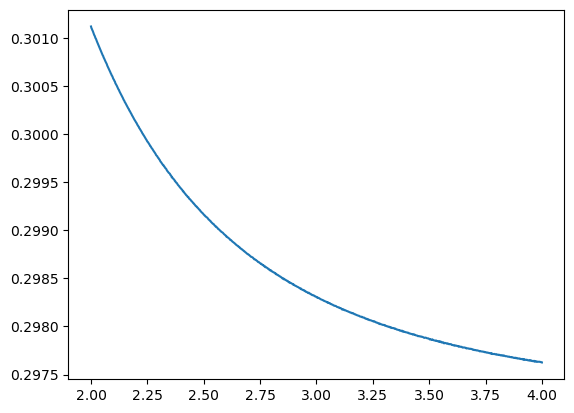

In [59]:
plt.plot(frequencies, I)
plt.show()

In [42]:
spectra_U = np.array(spectra_U)

In [43]:
spectra_U.shape

(1, 1001)

In [44]:
frequencies

array([2.        , 2.00200009, 2.00399995, ..., 3.99600005, 3.99799991,
       4.        ])

In [45]:
I

array([[0.30111826, 0.3011008 , 0.30109151, ..., 0.29763022, 0.29762544,
        0.29762516]])